# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-04-05 19:17:42--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-05 19:17:42 (34.2 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/f865b92/releases/pybind11-install.s

ModuleNotFoundError: ignored

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

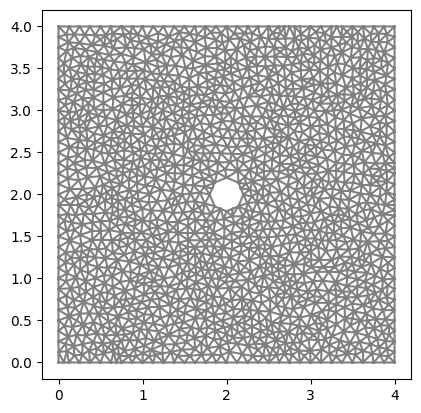

In [ ]:
# Define rectangular domain 
L = 4
H = 4

# Define circle
xc = 0.5*L
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 3)
QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

In [ ]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**

In [ ]:
# Set boundary penalty parameter gamma 
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# WHAT IS x ???? ==> the 2 first expressions don't work

# Set data that describe functional that defines the adjoint problem
#psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
#psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
#psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
#psi2 = Expression("0.0", element = Q.ufl_element())
psi1 = Expression(("1.0","0.0"), element = V.ufl_element())
psi2 = Expression("3.0", element = Q.ufl_element())
phi3 = Expression(("1.0","0.0"), element = V.ufl_element())
#psi_1 = (0,0)
#psi_2 = 0 
#phi_3 = (1,0)


# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system 
solve(res == 0, w) 

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system 
solve(res_a == 0, wa) 

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


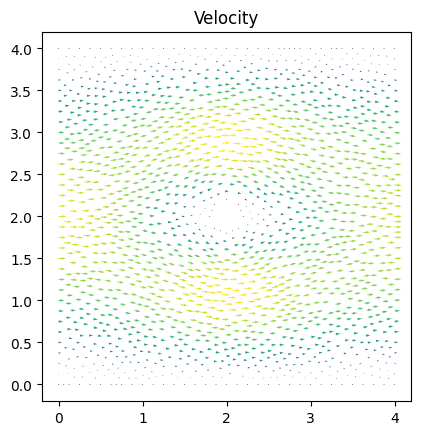

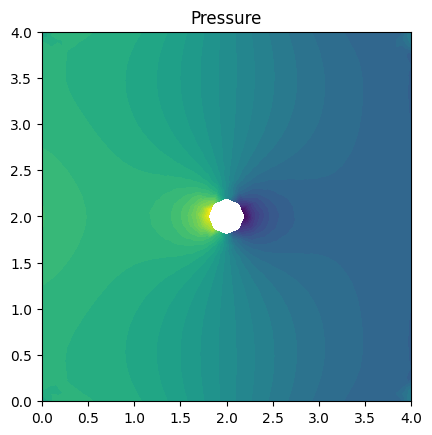

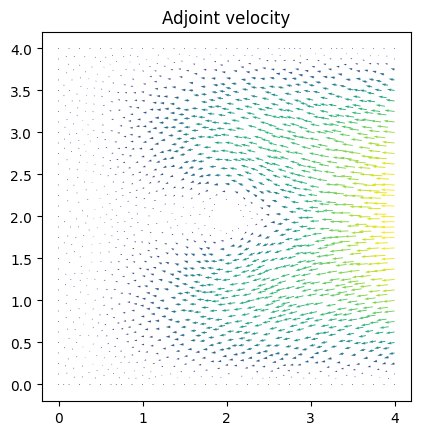

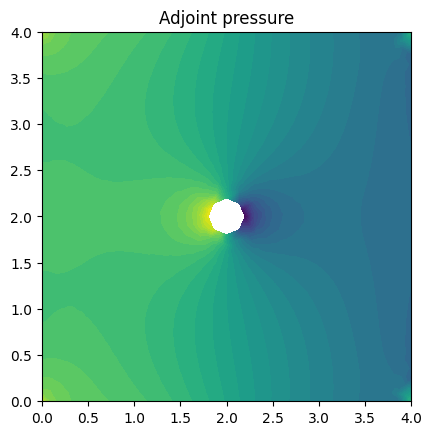

In [ ]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")
        
plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

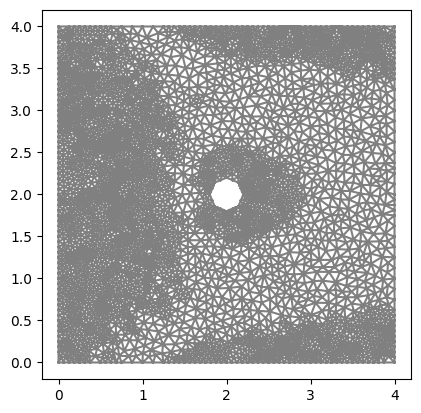

Total error = 0.019553663856901785


In [ ]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh 
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()] 
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err) 
print(s)

# **Discussion**

An adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

**Abstract**

In this lab I will study an adaptive method of mesh refinement. That is a very usefull tool to study unsteady flows without needed a huge mesh. It is also a good way of reducing the total error of a simulation by finding which parts of the mesh are needed to be refined to get the best solution. In this lab, the impact of certain parameters that control the refining method such as the drag force or the lift force will be investigated. I will also try this method on different mesh and more precisely I will observe that the position of a hole in the mesh will impact the refined mesh.

**Introduction**

1. The domain

Use the data to the adjoint problem which defines the functional equal to the drag force:

psi_1 = (0,0), psi_2 = 0 and psi_3 = (1,0)

Then change the height of the domain to H=L, and move the center of the circle over the domain. Describe how the adjoint solution and the local mesh refinement changes as a result. 

2. The functional 

Change the data to the adjoint problem (psi_1, psi_2, psi_3) and describe how the adjoint solution and the local mesh refinement changes as a result. 

**Methods**

In this lab, the code is solving the Stokes equation on a 2D rectangular mesh. In this mesh, there is a circular hole. To realise the best simulation I want to be as precise as possible on the draf and lift forces on the circular hole. That is why the code is using an adaptive refining method of the mesh. The method uses the total error that is computed with weak form of the adjoint Stokes equation.

**Results**

Q1 :
I started by using the functionnal equals to the drag force. This results to the definition of psi1, psi2 and phi3 as : psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
psi2 = Expression("0.0", element = Q.ufl_element())
phi3 = Expression(("1.0","0.0"), element = V.ufl_element()).

I used a mesh with :
- A cicular hole at $x = 0.3 ; y = 0.5H$ => this leads to a refined mesh around the circular hole and more especially at the inlet of the flow. The total error is -0.188. The adjoint pressure and the pressure are similar and pretty smooth. However the adjoint velocity has a very high magnitude and the gradients are also very high around the circular hole. 
- A cicular hole at $x = 0.5 ; y = 0.5H$ => this leads to a refined mesh around the circular hole and more especially at the inlet of the flow. The total error is 0.025. The adjoint pressure and the pressure are similar and pretty smooth. However the adjoint velocity has a high magnitude and the gradients are also high around the circular hole.
- A cicular hole at $x = 0.5L ; y = 0.5H$ => this leads to a refined mesh around the circular hole and at the bottom and at the top of the rectangular domain. The total error is 0.0069. The adjoint pressure and the pressure are identical whearas the adjoint velocity is completly different than the velocity. Indeed the adjoint velocity magnitude seems to be very high when the velocity magnitude is small, moreover it rotates above and below the circular hole while the velocity direction is mainly in the x direction.
- A cicular hole at $x = 0.5L ; y = 0.8H$ => this leads to a refined mesh around the circular hole but more especially below the circular hole and at the bottom of the rectangular domain. The total error is 0.0017. The adjoint pressure is again very similar to the pressure. And same behaviour than for the previous tests for the adjoint velocity.
- A cicular hole at $x = 3.5 ; y = 0.5H$ => this leads to a refined mesh around the circular hole and more especially at the outlet of the flow and at the bottom right and top right of the domain. The total error is 0.00057. The adjoint pressure and the pressure are similar and pretty smooth. However the adjoint velocity has a high magnitude and the gradients are also high around the circular hole. 

To conclude, when the circular hole is to close to the inlet the computation of the adjoint velocity seems quiete hard that results to a high total error. 

Q2 :
The flow is going from the left to the right side of the domain. Moreover, the flow is disturbed by a circular hole. Thus, I suppose that the adaptive mesh refinement would refine the mesh around the circular hole because that is where the flow is disturbed and at the inlet because if there is already an error at the inlet then it may impact the whole simulation. Furthermore, to compute precisely the no slip conditions at the top and bottom boundaries the mesh might need to be refined. 

Here are the different representers of the linear and bounded function that defines the adjoint problem (I kept a circular hole at $x = 0.5*L ; y = 0.5*H$):
- psi1 = (1,0) ; psi2 = 0 ; phi3 = (1,0) => this leads to a refined mesh around the circular hole and at the bottom and at the top of the rectangular domain. The total error is 0.0069. The adjoint pressure and the pressure are similar and pretty smooth. However the adjoint velocity has a high magnitude and the gradients are also high around the circular hole. Moreover, the direction of the adjoint velocity is mainly the x direction close to the circular hole.
- psi1 = (3,0) ; psi2 = 0 ; phi3 = (1,0) => this leads to a refined mesh around the circular hole and at the bottom and at the top of the rectangular domain. The total error is 0.0058. The adjoint velocity has not changed at all. However the adjoint pressure is now completly different and starts to present a plane wave behaviour (in the x direction).
- psi1 = (10,0) ; psi2 = 0 ; phi3 = (1,0) => this leads to a refined mesh around the circular hole and at the bottom and at the top of the rectangular domain. The total error is 0.0064. The adjoint velocity has not changed at all. However the adjoint pressure is now completly different and presents a plane wave behaviour (in the x direction).
- psi1 = (1,1) ; psi2 = 0 ; phi3 = (1,0) => this leads to a refined mesh around the circular hole and at the bottom and at the top of the rectangular domain (now, the refined mesh is not completly symmetrical according to the line at y = 0.5*L). The total error is 0.0069. The adjoint pressure and the pressure are still a bit similar and pretty smooth (the adjoint pressure has lost its symmetry). In addition, the adjoint velocity has changed a lot. Its behavior upstream and around the circular hole is the same but it has completly changed downstream.
- psi1 = (1,3) ; psi2 = 0 ; phi3 = (1,0) => this leads to a refined mesh around the circular hole and at the bottom and at the top of the rectangular domain (now, the refined mesh is not completly symmetrical according to the line at y = 0.5*L). The total error is 0.0055. The changes are in the same way of the previous simulation and more important. 
- psi1 = (1,0) ; psi2 = 1 ; phi3 = (1,0) => the mesh seems coarser in some locations and finer in a very large area at the inlet and close to the upper and lower right side of the domain. The total error is 0.011. The adjoint pressure has not changed a lot but the adjoint velocity has completely changed and is now in -x direction but a high magnitude on the right side of the domain and a small magnitude on the left side of the domain.
- psi1 = (1,0) ; psi2 = 3 ; phi3 = (1,0) => The total error is 0.018. Increasing the value of psi2 from 1 to 3 doesn't seem the impact the adjoint funtions and the refined mesh.